In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
import pathlib
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential
from IPython.display import Image
from keras import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras import datasets, layers, models, losses

In [2]:
dataset_dir = os.path.join(os.getcwd(), "CIFAKE")

img_height = 32
img_width = 32
batch_size = 500

# Load training and validation data
train, val = keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, "train"),
  validation_split=0.2,
  subset="both",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Using 20000 files for validation.


In [3]:
test = keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, "test"),
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 20000 files belonging to 2 classes.


In [4]:
classes = train.class_names
classes
len(train)

160

## LRN Version (Don't Use)

In [9]:
model_LRN = models.Sequential()
model_LRN.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(32,32,3)))
model_LRN.add(layers.Conv2D(96, 11, strides=4, padding='same'))
model_LRN.add(layers.Lambda(tf.nn.local_response_normalization))
model_LRN.add(layers.Activation('relu'))
model_LRN.add(layers.MaxPooling2D(3, strides=2))
model_LRN.add(layers.Conv2D(256, 5, strides=4, padding='same'))
model_LRN.add(layers.Lambda(tf.nn.local_response_normalization))
model_LRN.add(layers.Activation('relu'))
model_LRN.add(layers.MaxPooling2D(3, strides=2))
model_LRN.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model_LRN.add(layers.Activation('relu'))
model_LRN.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model_LRN.add(layers.Activation('relu'))
model_LRN.add(layers.Conv2D(256, 3, strides=4, padding='same'))
model_LRN.add(layers.Activation('relu'))
model_LRN.add(layers.Flatten())
model_LRN.add(layers.Dense(4096, activation='relu'))
model_LRN.add(layers.Dropout(0.5))
model_LRN.add(layers.Dense(4096, activation='relu'))
model_LRN.add(layers.Dropout(0.5))
model_LRN.add(layers.Dense(1, activation='sigmoid'))
model_LRN.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 56, 56, 96)        0         
                                                                 
 activation (Activation)     (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         614656    
                                                      

In [12]:
model_LRN.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")])

In [13]:
historyLRN = model_LRN.fit(
  train,
  validation_data=val,
  epochs=40,
  verbose=0)

historyLRN = pd.DataFrame(historyLRN.history)
display(historyLRN)

KeyboardInterrupt: 

## Batch Normalization Version

In [5]:
keras.backend.clear_session()
model = keras.models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.Resizing(227, 227, interpolation="bilinear"),
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 resizing (Resizing)         (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       6

In [7]:
model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")])

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [9]:
epochs = 40

history = model.fit(
  train,
  validation_data=val,
  epochs=epochs,
  verbose=0, callbacks=[es])

history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,1.987875,0.651700,0.638967,0.696911,0.737720,0.55860,0.533529,0.942986
1,0.450741,0.785425,0.781834,0.791572,0.583179,0.69855,0.653331,0.847928
2,0.306227,0.869963,0.871932,0.867200,1.485706,0.54390,0.523354,0.999101
3,0.226192,0.909425,0.909904,0.908766,0.264250,0.89055,0.894694,0.885671
4,0.187853,0.926912,0.927345,0.926347,0.231667,0.90800,0.891486,0.929406
5,0.168742,0.935088,0.936252,0.933700,1.286173,0.57840,0.997486,0.158462
6,0.160349,0.938950,0.939939,0.937777,0.219381,0.91300,0.923187,0.901248
7,0.147500,0.944313,0.944169,0.944429,0.209065,0.91640,0.947538,0.881877
8,0.135556,0.948762,0.948575,0.948931,0.157443,0.93940,0.938004,0.941188
9,0.125790,0.952450,0.952319,0.952557,0.368465,0.85180,0.992182,0.709636


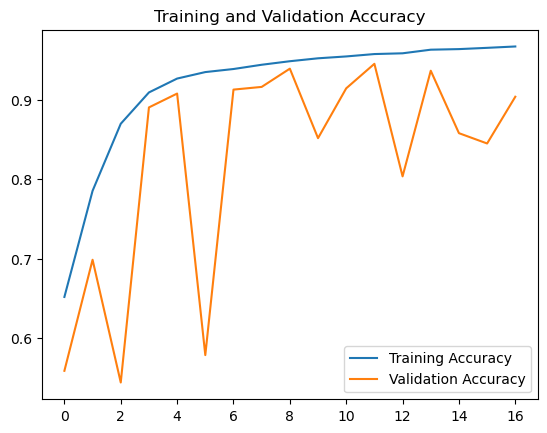

In [10]:
plt.plot(range(len(history)), history["accuracy"], label="Training Accuracy")
plt.plot(range(len(history)), history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

In [11]:
model.evaluate(test, return_dict=True)

40/40 [==============================] - 7s 123ms/step - loss: 0.1507 - accuracy: 0.9438 - precision: 0.9668 - recall: 0.9193


{'loss': 0.1506645232439041,
 'accuracy': 0.9438499808311462,
 'precision': 0.9667683243751526,
 'recall': 0.9193000197410583}

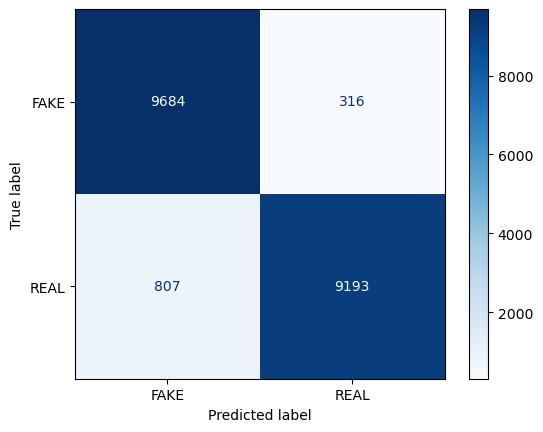

In [12]:
# Confusion matrix
test_predictions = np.array([])
test_labels = np.array([])
for x, y in test:
    test_predictions = np.append(test_predictions, model(x) > 0.5)
    test_labels = np.append(test_labels, y)
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, display_labels=classes, cmap="Blues");